In [71]:
import pandas as pd
#import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from eqUtils import *

In [72]:
# mapping imports
import os
os.environ["PROJ_LIB"]='~/anaconda3/envs/earthquake-libcomcat/share/'
from mpl_toolkits.basemap import Basemap
import geopandas as gpd

## Parameters

Find all events within 100km of Lindsborg.
- latitude = 38.5735
- longitude = -97.6745

## Update history and read data

In [119]:
!python update-history.py
hist_df = pd.read_pickle('historyDF.pkl')

## Plot

### Time series

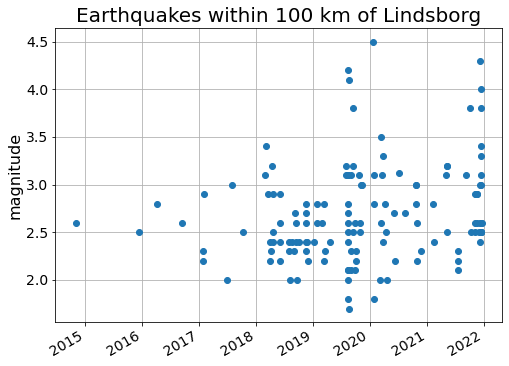

In [120]:
x = mdates.date2num(hist_df.index)
y = hist_df['magnitude']

fig_hist, ax = plt.subplots(figsize=(8,6))
plt.plot_date(x,y)
plt.gcf().autofmt_xdate()

plt.ylabel('magnitude', size=16)
plt.title('Earthquakes within 100 km of Lindsborg', size=20)
plt.grid()
ax.tick_params(axis='both', labelsize=14)

### Map

In [121]:
kansas = gpd.read_file('mapfiles/tl_2017_20_place.shp')

plotlat = hist_df['latitude'].to_numpy()
plotlong = hist_df['longitude'].to_numpy()
plotmag = hist_df['magnitude'].to_numpy()

Text(535000.0, 610000.0, 'Lindsborg')

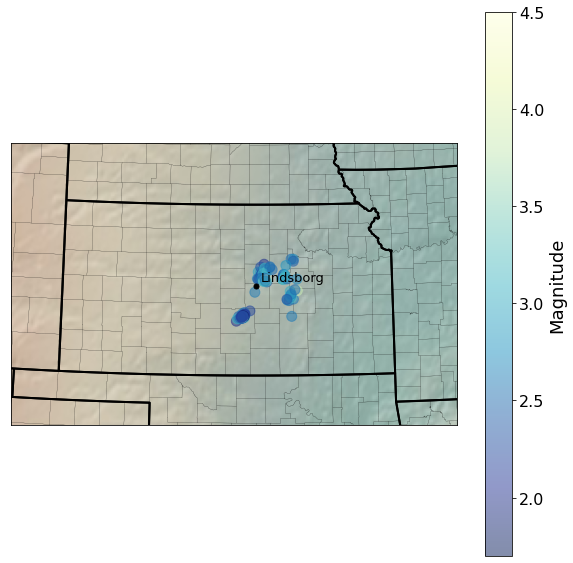

In [122]:
fig_map = plt.figure(figsize=(10, 10))
m = Basemap(projection='lcc', resolution='h',
            lat_0=38.5735, lon_0=-97.6745,
            width=1.05E6, height=1.2E6)
m.shadedrelief()
m.drawstates(linewidth=2)
m.drawcounties()

# extent in lat/lon (dec degrees)
ulx = -103
uly = 41
lrx = -93
lry = 36

# transform coordinates to map projection
xmin, ymin = m(ulx, lry)
xmax, ymax = m(lrx, uly)

# set the axes limits
ax = plt.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# add events
m.scatter(plotlong, plotlat, latlon=True,
          c=plotmag, s=100,
          cmap='YlGnBu_r', alpha=0.5)

# create colorbar
cb = plt.colorbar()
cb.set_label(label=r'Magnitude', size=18)
cb.ax.tick_params(labelsize=16)
plt.clim(plotmag.min(), plotmag.max())

# lindsborg
x,y = m(-97.6745,38.5735)
plt.plot(x,y, 'ok', markersize=5)
plt.text(x+10000,y+10000,'Lindsborg', fontsize=13)